In [3]:
# load necessary packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# these packages are needed to fit logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as seabornInstance 
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm

/Users/supertramp/anaconda3/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [4]:
data = pd.read_csv('conversion_data.csv')
data.shape
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Lets look at the distribution of variables

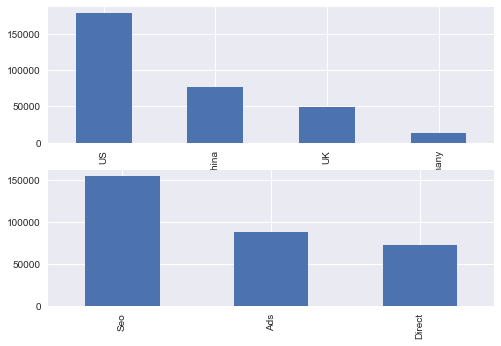

In [5]:
# categorical variables first
plt.figure
plt.subplot(211)
pd.Series(data['country']).value_counts().plot('bar')

plt.subplot(212)
pd.Series(data['source']).value_counts().plot('bar')
plt.savefig('Cat_var')
plt.show()

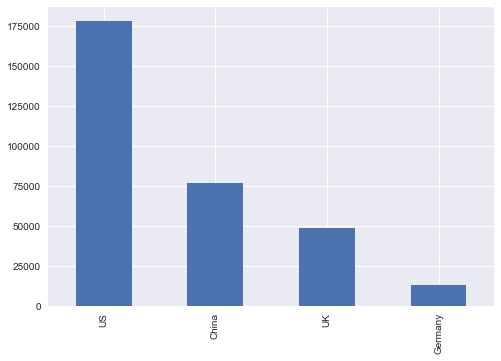

In [6]:
# categorical variables first
plt.figure
plt.subplot(111)
pd.Series(data['country']).value_counts().plot('bar')
plt.savefig('Cat_var')
plt.show()

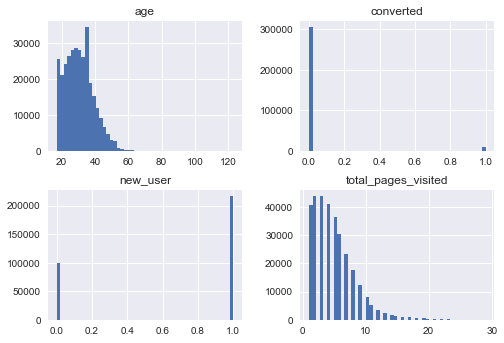

In [90]:
# then binary and numerical variables
data.hist(bins = 50)
plt.savefig('numeric_var')
plt.show()


From looking at the data, we can tell that most website visitors are:
1) 20-40 years old
2) are from the US, followed by China
3) found the website via search engine

In [91]:
# check for imbalances in your dependent variable
y = data['converted']
y.value_counts()
count_no_conv = len(y[y==0])
count_conv = len(y[y==1])
pct_of_no_conv = count_no_conv/(count_no_conv+count_conv)
print("percentage of no conversion is", pct_of_no_conv*100)
pct_of_conv = count_conv/(count_no_conv+count_conv)
print("percentage of conversion", pct_of_conv*100)

percentage of no conversion is 96.7741935483871
percentage of conversion 3.225806451612903


The conversion rate is fairly low: 3.23% of all visitors. This is important information for building a model, since what we are trying to predict occurs very rarely in our data. 

In [92]:
# let's see how many visitors return vs how many visitors are new
y = data['new_user']
y.value_counts()
count_old = len(y[y==0])
count_new = len(y[y==1])
pct_of_old = count_old/(count_old+count_new)
print("percentage of returning users", pct_of_old*100)
pct_of_new = count_new/(count_old+count_new)
print("percentage of new users", pct_of_new*100)

percentage of returning users 31.453510436432637
percentage of new users 68.54648956356736


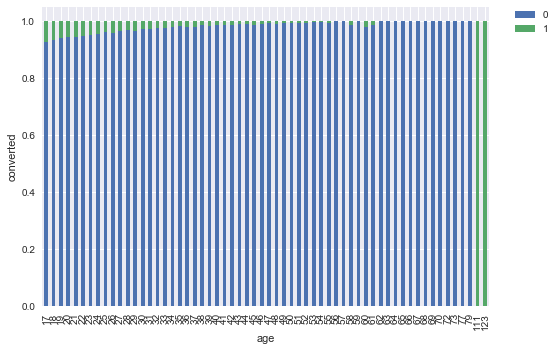

In [93]:
# lets see what are the means in each outcome
plt.figure()
table=pd.crosstab(data.age,data.converted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.xlabel('age')
plt.ylabel('converted')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.s
plt.show()

This is hard to see but we can tell that younger visitors were more likely to convert than older visitors.


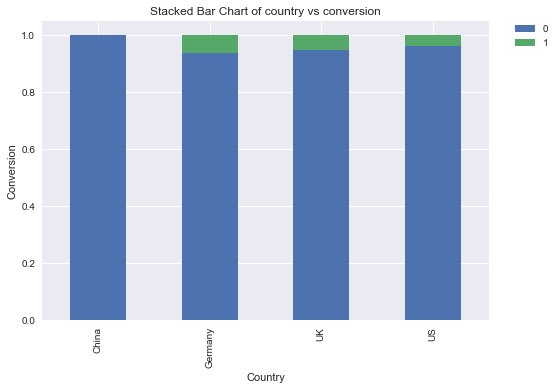

In [94]:
ax=plt.figure()
table=pd.crosstab(data.country,data.converted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of country vs conversion')
plt.xlabel('Country')
plt.ylabel('Conversion')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('Country')
plt.show()


Interestingly, visitors from China were least likely to convert. 
Visitors from Germany were most likely to convert

In [95]:
data.groupby('country').mean()



,age,new_user,total_pages_visited,converted
country,,,,
China,30.672972,0.698520,4.553523,0.001332
Germany,30.449985,0.677237,5.190717,0.062500
UK,30.451538,0.679835,5.082167,0.052632
US,30.566482,0.681985,4.930160,0.037801


It looks like visitors from China were similar age as visitors from other countries. They also were similarly likely to be be new to the site. They spent slightly less time on the website, and where least likely to buy something.

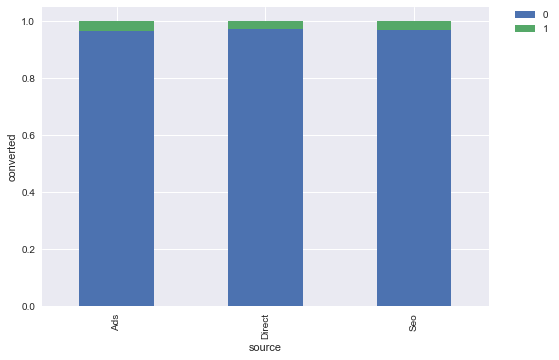

In [96]:
plt.figure()
table=pd.crosstab(data.source,data.converted)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.xlabel('source')
plt.ylabel('converted')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig('Source')
plt.show()

# the way customer got to the site doesn't seem to affect the outcome

Level of conversion does not appear to depend on how the visitors found the site. 

In [69]:
data.groupby('converted').mean()


,age,new_user,total_pages_visited
converted,,,
0,30.703961,0.698382,4.550281
1,26.546765,0.297941,14.553529


Importantly, new users were less likely to convert. 
Additionally, the longer visitors spent on the website, the more likely they were to convert.

Let's try to create a model to see what information about the visitors can actually predict whether they are going to buy something.

We should use logistic regression, because we are predicting binary outcome (0 - no conversion, 1 - conversion)

In [70]:
# create dummies for categorical variables

cat_vars=['country', 'source']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars] # combine dummies and numeric variables

In [71]:
# these are our dummy coded variables + binary and numerical variables
data_final=data[to_keep]
data_final.columns.values

array(['age', 'new_user', 'total_pages_visited', 'converted',
       'country_China', 'country_Germany', 'country_UK', 'country_US',
       'source_Ads', 'source_Direct', 'source_Seo'], dtype=object)

In [72]:
# oversample converted outcome in training data

# split data into predictors and outcome
X = data_final.loc[:, data_final.columns != 'converted']
y = data_final.loc[:, data_final.columns == 'converted']

# now, we need to split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

# one strategy to deal with unbalanced outcome is oversample less frequent outcome 
# to create balance
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['converted'])

# we can check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no conversion",len(os_data_y[os_data_y['converted']==0]))
print("Number of converted in oversampled data",len(os_data_y[os_data_y['converted']==1]))
print("Proportion of no conversion data in oversampled data is ",len(os_data_y[os_data_y['converted']==0])/len(os_data_X))
print("Proportion of conversion data in oversampled data is ",len(os_data_y[os_data_y['converted']==1])/len(os_data_X))


length of oversampled data is  428510
Number of no conversion 214255
Number of converted in oversampled data 214255
Proportion of no conversion data in oversampled data is  0.5
Proportion of conversion data in oversampled data is  0.5


Great! let's now fit our logistic regression. 

In [73]:
X=os_data_X
y=os_data_y
logit_model=sm.Logit(y,X)
result=logit_model.fit(method = 'nm')
print(result.summary2())

                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.013      
Dependent Variable:  converted        AIC:              586466.7945
Date:                2020-05-21 23:39 BIC:              586576.4752
No. Observations:    428510           Log-Likelihood:   -2.9322e+05
Df Model:            9                LL-Null:          -2.9702e+05
Df Residuals:        428500           LLR p-value:      0.0000     
Converged:           0.0000           Scale:            1.0000     
No. Iterations:      35.0000                                       
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
age                 -0.0011   0.0004 -3.2061 0.0013 -0.0018 -0.0004
new_user            -0.0012   0.0067 -0.1782 0.8586 -0.0143  0.0119
total_pages_visited  0.0030   0.0005  5.5930 0.0000  0.0020  0.0041
country

From looking at our model, we see that age and total pages visited are main predictors of conversion. Interstingly, new_user variable is not predictive, which we would expect that from looking at the means. This could potentially be due to imbalance in that variable. 

In [74]:
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [75]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on training set: 0.95
Accuracy of logistic regression classifier on test set: 0.95


The model's accuracy is above 50%, the model does equally well in training and test dataset, thus it is not fitting noise. 

In [76]:
# checking precision and recall
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     64508
           1       0.95      0.96      0.95     64045

    accuracy                           0.95    128553
   macro avg       0.95      0.95      0.95    128553
weighted avg       0.95      0.95      0.95    128553



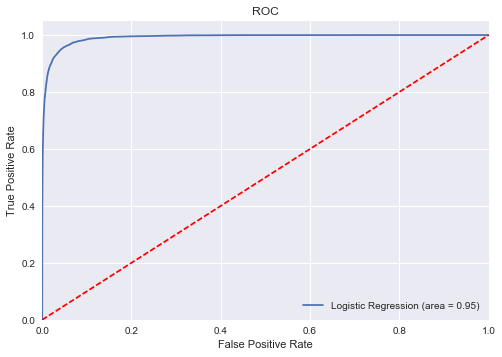

In [77]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.savefig('Log_ROC')
plt.show()


By evaluation measurements, our model is doing well. But it is suspicious that new_user was not predictive of conversion, since at least from looking at the means, it seemed like visitors who converted were repreated visitors. This needs additional changes. 

Recommendations:
    1) Rate of conversion was dependent on age (most customers were younger), to increase conversion rate I would recommend trying to appeal to older customers (They are also more likely to be finacially stable).
    2) Increasing the time that visitors spend on the websites usually leads to higher conversion rate, thus making it easier to browse the site might boost sales.
    3) It appears that the visitors from China are least likely to buy products on the website. The demographics of Chinese visitors did not differ from other customers. Thus, it appears that the products on the website are just not appealing to the customers. Marketing to customers from that region can potentially boost sales. 